# Example 2: Walter 1994 in 1D. Migration of precipitation/dissolution fronts

This test problem is a one-dimensional, purely inorganic redox problem that was first presented by Walter et al. (1994). It  was subsequently used as a benchmark problem by Guerin and Zheng (1998). It demonstrates the evolution of some important geochemical processes that occur when acidic mine tailings leach into an anaerobic carbonate aquifer. Aqueous complexation and dissolution/precipitation are all considered as equilibrium reactions. If the reaction network defined by Walter et al. (1994) is used, the simulation includes 17 aqueous components, 15 of which are transported, 54 aqueous species and six minerals.

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
import flopy
from mf6rtm import utils
from mf6rtm import mf6rtm
import re
import difflib

prefix = 'ex2'
DT_FMT = "%Y-%m-%d %H:%M:%S"
dataws = os.path.join("data")
databasews = os.path.join("database")


#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 1  # Number of layers
Lx = 0.4 #m
ncol = 80 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 1  # Time step ($days$)
perlen = 24  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#injection
q = 0.007 #injection rate m3/d
wel_spd = [[(0,0,0), q]]


#hydraulic properties
prsity = 0.35  # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*1
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
r_hd = 1
strt = np.ones((nlay, nrow, ncol), dtype=float)

chdspd = [[(i, 0, ncol-1), r_hd] for i in range(nlay)] # Constant head boundary $m$

#transport
dispersivity = 0.005 # Longitudinal dispersivity ($m$)
disp_tr_vert = dispersivity*0.1 # Transverse vertical dispersivity ($m$)


icelltype = 1  # Cell conversion type

# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

## Initialize Chemistry in Domain

In [3]:
files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)

#get postfix file
solutionsdf

,sol_bck,sol_tail
comp,,
pH,6.960000e+00,3.990000e+00
pe,1.670000e+00,7.690000e+00
C(+4),3.940000e-03,4.920000e-04
S(6),7.480000e-03,5.000000e-02
Fe(+2),5.390000e-05,3.060000e-02
Fe(+3),2.320000e-08,1.990000e-07
Mn(+2),4.730000e-05,9.830000e-06
Ca,6.920000e-03,1.080000e-02
Mg,1.960000e-03,9.690000e-04


In [4]:
# get equilibrium phases file
equilibrium_phases = utils.equilibrium_phases_csv_to_dict(os.path.join(dataws, f'{prefix}_equilibrium_phases.csv'))
equilibrium_phases


# equlibrium phases is a dictionary with keys as the phase number, values is another dictionary with phase name and an array of saturation indices as element 0 and concentrations as element 1. multiply the concentrations by 2
for key, value in equilibrium_phases.items():
    for k, v in value.items():
        v[-1] = mf6rtm.concentration_volbulk_to_volwater( v[-1], prsity)
equilibrium_phases

{1: {'Calcite': [0.0, 0.018000000000000002],
  'Siderite': [0.0, 0.005188857142857143],
  'Gibbsite': [0.0, 0.0025177142857142855],
  'Fe(OH)3(a)': [0.0, 0.00186],
  'Gypsum': [0.0, 0.0],
  'SiO2(a)': [0.0, 0.407]}}

In [5]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=float)

#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

#create equilibrium phases class
equilibrium_phases = mf6rtm.EquilibriumPhases(equilibrium_phases)
eqp_ic = 1

equilibrium_phases.set_ic(eqp_ic)

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}', f'mf6rtm'))

#set database
database = os.path.join(databasews, f'pht3d_datab_walter1994.dat')
model.set_database(database)

#include equilibrium phases in model class
model.set_equilibrium_phases(equilibrium_phases)

postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)

In [6]:
model.set_charge_offset(0.0)

In [7]:
#initialize model
model.initialize()

Using temperatue of 25.0 for all cells
Phreeqc initialized


## Initialize Inflow Chemistry

In [8]:
wellchem = mf6rtm.ChemStress('wel')
sol_spd = [2]
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)


Initializing ChemStress
ChemStress wel initialized


In [9]:
for i in range(len(wel_spd)):
    wel_spd[i].extend(model.wel.data[i])
print(wel_spd)

[[(0, 0, 0), 0.007, 110692.76183170642, 55550.81484856792, -0.07000281594576051, 4.287284994678123, 0.4905451627039263, 10.76806454719058, 0.11864811862182253, 30.509714628599696, 0.7906551098076068, 0.9661346802062664, 0.009800932823970994, 1.3858897889439776, 49.85215072264949, 2.073849468347822]]


## Build MF6 model

In [10]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    
    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = model.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        # auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # for i in range(len(chdspd_tail)):
    #     chdspd_tail[i].extend(model.chdtail.data[0])
    # # Instantiating MODFLOW 6 constant head package
    # chd_tail = flopy.mf6.ModflowGwfchd(
    #     gwf,
    #     maxbound=len(chdspd_tail),
    #     stress_period_data=chdspd_tail,
    #     auxiliary=mup3d.components,
    #     save_flows=True,
    #     pname="CHDTAIL",
    #     filename=f"{gwfname}.chdtail",
    # )
    # chd_tail.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()

        # # cncspd = {0: [[(0, 0, col), conc] for col, conc in zip(range(ncol), model.sconc[c][0,0,:])]}
        # cncspd = {0: [[(ly, 0, 0), model.sconc[c][ly,0,0]] for ly in range(3,nlay)]}

        # # print(cncspd)
        # cnc = flopy.mf6.ModflowGwtcnc(gwt,
        #                                 # maxbound=len(cncspd),
        #                                 stress_period_data=cncspd,
        #                                 save_flows=True,
        #                                 print_flows = True,
        #                                 pname="CNC",
        #                                 filename=f"{gwtname}.cnc",
        #                                 )
        # cnc.set_all_data_external()
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1 # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))**dispersivity*0.1   # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [11]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---


--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Al
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: C
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Fe
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: K
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Mg
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Mn
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Na
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: S
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---


--- Building MST package ---
--- Building OC package ---
Setting model for component: Si
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing solution package ims_1...
  writing solution package ims_2...
  writing solution package ims_3...
  writing solution package ims_4...
  writing solution package ims_5...
  writing solution package ims_6...
  writing solution package ims_7...
  writing solution package ims_8...
  writing solution package ims_9...
  writing solution package ims_10...
  writing solution package ims_11...
  writing solution package ims_12...
  writing solution package ims_13...
  writing package H.gwfgwt...
  writing package O.gwfgwt...
  writing package Charge.gwfgwt...
  wri

    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Na...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model S...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Si...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...


In [12]:
model.run_mup3d(sim, reaction=True)



-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Al, C, Ca, Cl, Fe, K, Mg, Mn, Na, S, Si


Starting transport solution at 2024-08-06 12:53:08

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00027513 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took 0.00035847 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 18 iters --- took 0.00044362 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 23 iters --- took 0.00049367 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 1 --- converged with 31 iters --- took 0.00057703 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 1 --- converged with 38 iters --- took 0.00064183 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Tra

Transport stress period: 1 --- time step: 2 --- converged with 60 iters --- took 0.00083342 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 2 --- converged with 69 iters --- took 0.00092522 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 2 --- converged with 75 iters --- took 0.00099188 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 2 --- converged with 82 iters --- took  0.0010752 mins

Solution 11 finalized

Solving solution 12 - Solving Mn
Transport stress period: 1 --- time step: 2 --- converged with 87 iters --- took  0.0011586 mins

Solution 12 finalized

Solving solution 13 - Solving Na
Transport stress period: 1 --- time step: 2 --- converged with 92 iters --- took  0.0012252 mins

Solution 13 finalized

Solving solution 14 - Solving S
Transport stress period: 1 --- time step: 2 --- converged with 101 iters --- took


Getting concentration arrays --- time step: 3 --- elapsed time: 2.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 4 --- converged with 0 iters --- took 0.00026778 mins

Solution 1 finalized

Solving solution 2 - S

Transport stress period: 1 --- time step: 5 --- converged with 43 iters --- took 0.00062908 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 5 --- converged with 52 iters --- took 0.00070572 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 5 --- converged with 58 iters --- took 0.00078928 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 5 --- converged with 68 iters --- took 0.00088927 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 5 --- converged with 73 iters --- took 0.00095598 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 5 --- converged with 79 iters --- took  0.0010393 mins

Solution 11 finalized

Solving solution 12 - Solving Mn
Transport stress period: 1 --- time step: 5 --- converged with 83 iters --- took  0.


Getting concentration arrays --- time step: 6 --- elapsed time: 5.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 7 --- converged with 0 iters --- took 0.00021675 mins

Solution 1 finalized

Solving solution 2 - S

Transport stress period: 1 --- time step: 8 --- converged with 34 iters --- took 0.00053408 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 8 --- converged with 43 iters --- took  0.0006346 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 8 --- converged with 52 iters --- took 0.00071823 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 8 --- converged with 56 iters --- took 0.00078465 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 8 --- converged with 66 iters --- took  0.0008513 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 8 --- converged with 70 iters --- took  0.0009264 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 8 --- converged with 74 iters --- took 0.0009


Getting concentration arrays --- time step: 9 --- elapsed time: 8.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 10 --- converged with 0 iters --- took 0.00023335 mins

Solution 1 finalized

Solving solution 2 - 


Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 11 --- converged with 41 iters --- took 0.00067867 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 11 --- converged with 49 iters --- took   0.000762 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 11 --- converged with 53 iters --- took 0.00082888 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 11 --- converged with 62 iters --- took 0.00092705 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 11 --- converged with 66 iters --- took  0.0010103 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 11 --- converged with 70 iters --- took  0.0010604 mins

Solution 11 finalized

Solving solution 12 - Solving Mn
Transport stress period: 1 --- time step: 11 -


Getting concentration arrays --- time step: 12 --- elapsed time: 11.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 13 --- converged with 0 iters --- took 0.00023333 mins

Solution 1 finalized

Solving solution 2 

Transport stress period: 1 --- time step: 14 --- converged with 33 iters --- took 0.00056505 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 14 --- converged with 41 iters --- took 0.00063183 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 14 --- converged with 50 iters --- took 0.00071695 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 14 --- converged with 55 iters --- took 0.00077713 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 1 --- time step: 14 --- converged with 65 iters --- took 0.00087887 mins

Solution 9 finalized

Solving solution 10 - Solving K
Transport stress period: 1 --- time step: 14 --- converged with 69 iters --- took 0.00094557 mins

Solution 10 finalized

Solving solution 11 - Solving Mg
Transport stress period: 1 --- time step: 14 --- converged with 74 iters --- took


Solving solution 15 - Solving Si
Transport stress period: 1 --- time step: 15 --- converged with 102 iters --- took  0.0014931 mins

Solution 15 finalized

Getting concentration arrays --- time step: 15 --- elapsed time: 14.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 17 --- converged with 0 iters --- took 0.00025007 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 17 --- converged with 13 iters --- took 0.00035015 mins

Solution 2 fi


Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 18 --- converged with 22 iters --- took 0.00044453 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 18 --- converged with 25 iters --- took  0.0005112 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 18 --- converged with 33 iters --- took 0.00057788 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 18 --- converged with 43 iters --- took   0.000663 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 18 --- converged with 52 iters --- took 0.00074453 mins

Solution 7 finalized

Solving solution 8 - Solving Cl
Transport stress period: 1 --- time step: 18 --- converged with 56 iters --- took 0.00079455 mins

Solution 8 finalized

Solving solution 9 - Solving Fe
Transport stress period: 


Getting concentration arrays --- time step: 19 --- elapsed time: 18.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 20 --- converged with 0 iters --- took 0.00026647 mins

Solution 1 finalized

Solving solution 2 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 21 --- converged with 0 iters --- took 0.00025157 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 21 --- converged with 12 iters --- took 0.00035163 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 21 --- converged with 23 iters --- took 0.00043495 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 21 --- converged with 29 iters --- took 0.00050162 mins

Solution 4 finalized

Solving solution 5 - Solving Al
Transport stress period: 1 --- time step: 21 --- converged with 37 iters --- took  0.0005882 mins

Solution 5 finalized

Solving solution 6 - Solving C
Transport stress period: 1 --- time step: 21 --- converged with 46 iters --- took 0.00065485 mins

Solution 6 finalized

Solving solution 7 - Solving Ca
Transport stress period: 1 --- time step: 21 --


Solving solution 15 - Solving Si
Transport stress period: 1 --- time step: 22 --- converged with 95 iters --- took  0.0013748 mins

Solution 15 finalized

Getting concentration arrays --- time step: 22 --- elapsed time: 21.0

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Al

Transferring concentrations to mf6 for component: C

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: Fe

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: Mg

Transferring concentrations to mf6 for component: Mn

Transferring concentrations to mf6 for component: Na

Transferring concentrations to mf6 for component: S

Transferring concentrations to mf6 for component: Si

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 24 --- converged with 0 iters --- took 0.00025007 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 24 --- converged 


Reactive transport solution finished at 2024-08-06 12:53:12 --- it took:   0.061561 mins



MR BEAKER IMPORTANT MESSAGE: SOMETHING WENT WRONG. BUMMER



True

In [13]:
def get_lst_budget(ws='.', comp = '', start_datetime=None):
    budgetkey  = 'MASS BUDGET FOR ENTIRE MODEL'
    lst = flopy.utils.Mf6ListBudget(os.path.join(ws,f"{comp}.lst"), budgetkey = budgetkey)
    inc,cum = lst.get_dataframes(start_datetime=start_datetime)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "time"
    cum.index.name = "time"
    return inc, cum

In [14]:
inc, cum = get_lst_budget(ws = os.path.join(model.wd), comp = 'K')
inc

,storage-aqueous-in,wel-in,chd-in,total-in,storage-aqueous-out,wel-out,chd-out,total-out,in-out,percent-discrepancy
time,,,,,,,,,,
1.0,0.0,0.005535,0.0,0.005535,0.005071,0.0,0.000464,0.005535,1.301000e-17,0.0
2.0,0.0,0.005535,0.0,0.005535,0.005071,0.0,0.000464,0.005535,1.734700e-17,0.0
3.0,0.0,0.005535,0.0,0.005535,0.005070,0.0,0.000464,0.005535,2.515300e-17,0.0
4.0,0.0,0.005535,0.0,0.005535,0.005070,0.0,0.000464,0.005535,3.382700e-17,0.0
5.0,0.0,0.005535,0.0,0.005535,0.005070,0.0,0.000465,0.005535,3.642900e-17,0.0
6.0,0.0,0.005535,0.0,0.005535,0.005068,0.0,0.000467,0.005535,3.989900e-17,0.0
7.0,0.0,0.005535,0.0,0.005535,0.005063,0.0,0.000471,0.005535,4.163300e-17,0.0
8.0,0.0,0.005535,0.0,0.005535,0.005053,0.0,0.000482,0.005535,5.117400e-17,0.0
9.0,0.0,0.005535,0.0,0.005535,0.005032,0.0,0.000502,0.005535,4.683800e-17,0.0


## Plots

In [15]:
wd = os.path.join(f'{prefix}', f'pht3d')
# dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

#offset index of simapi by tstep
simapi.index = simapi.index + tstep

simapi

# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]

#read pht3dpy file
ucndic = {}
pht3dpy = os.path.join(wd, pht3dpy[0])
with open(pht3dpy, 'r') as f:
    # print(f.read())
    for l in f:
        n =re.findall(r'\d+', l.split()[-1])[-1]
        ucndic[l.split()[0].replace('_', "")] = f"PHT3D{n}.UCN"
        
for k,v in ucndic.items():
    ucn = flopy.utils.HeadFile(os.path.join(wd, v),text=f"concentration")
    results = ucn.get_alldata()
    ucndic[k] = results
timespht3d = ucn.get_times()
    
for var in simapi.columns:
    closest_match = find_closest_match(var, ucndic)
    if closest_match:
        ucndic[var] = ucndic.pop(closest_match)



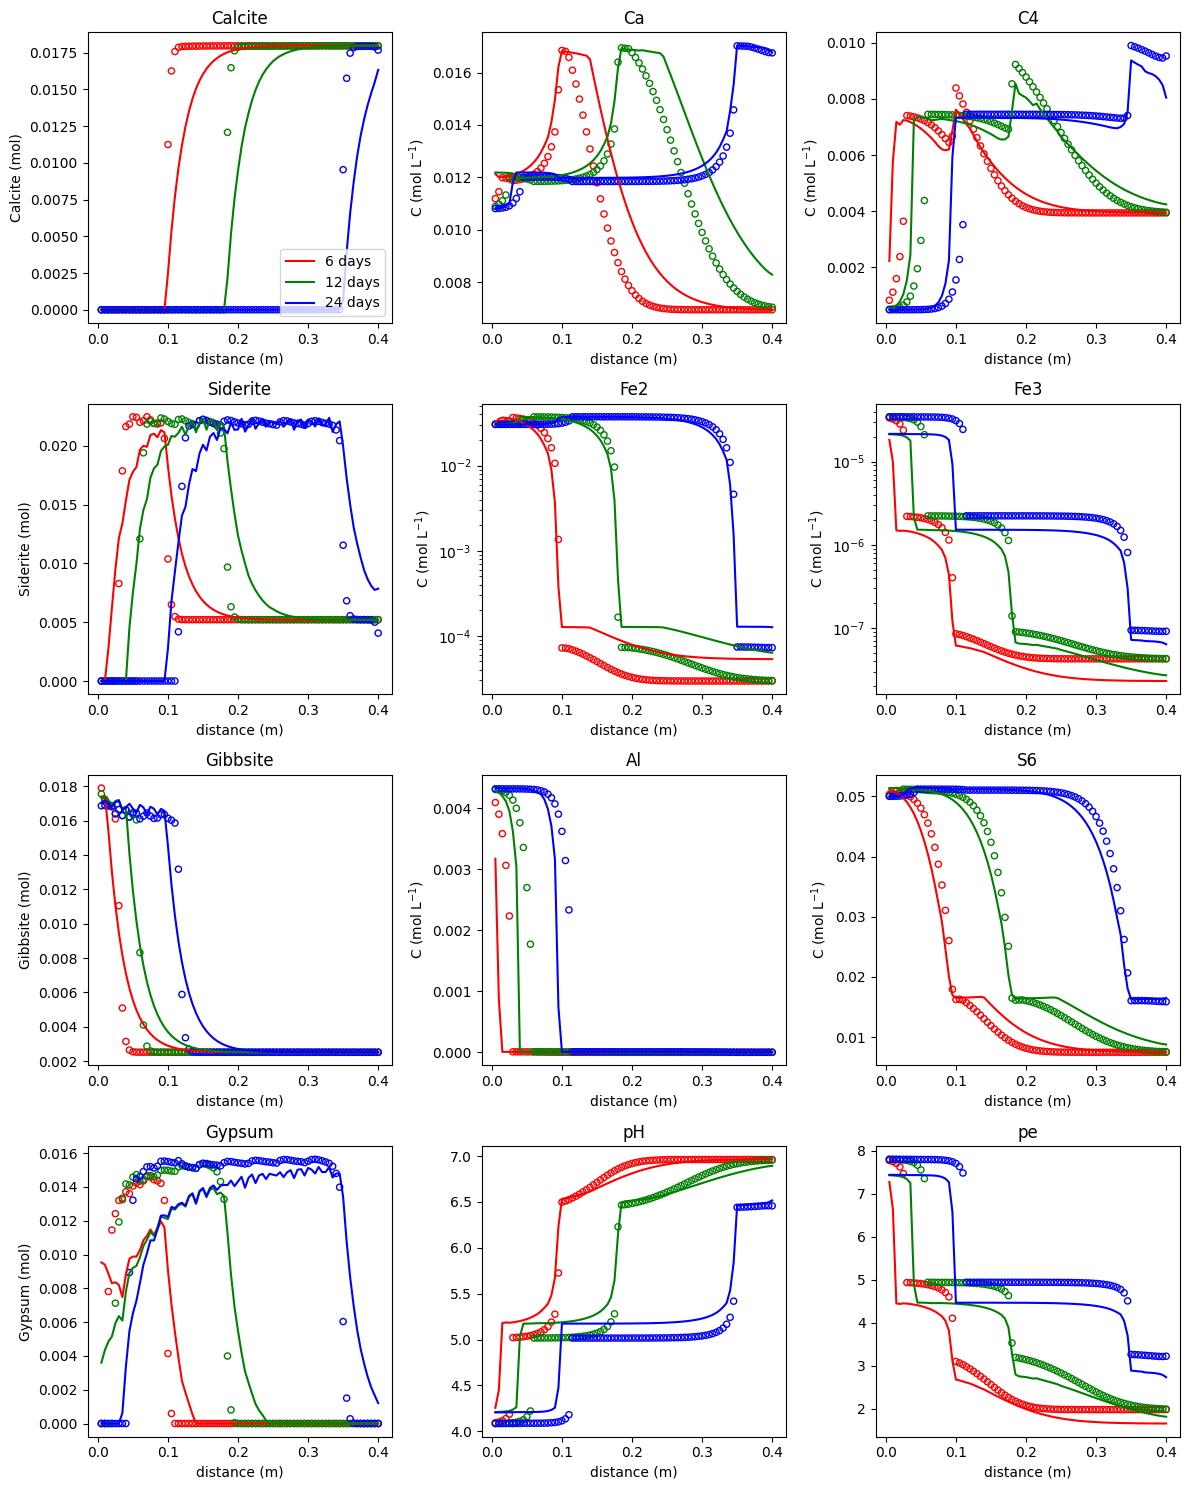

In [16]:
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr
# simdf.drop(columns = 'H', inplace = True)

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr
simapi.index = [round(i, 2) for i in simapi.index]
simapi = simapi[simdf.columns]

vars_to_plot = ['Calcite', 'Ca',  'C4', 'Siderite', 'Fe2', 'Fe3', 'Gibbsite',  'Al', 'S6','Gypsum',  'pH', 'pe']
plot_cols = 3
plot_rows = calc_rows_from_ncol(vars_to_plot, ncols=plot_cols)
fig, axs = plt.subplots(plot_rows,plot_cols, figsize = (12, 15))

colors = ['r', 'g', 'b']
times_to_plot = [6., 12., 24.]
for var, ax in zip(vars_to_plot, axs.flatten()):

    for t in times_to_plot:
        ax.plot(simapi.x.unique(), simapi.loc[t, var].values,label = f'{round(t)} days', c = colors[times_to_plot.index(t)])
        ax.scatter(simdf.x.unique(), simdf.loc[t, var], edgecolors=colors[times_to_plot.index(t)], 
                   facecolors='none', s=20)
        if var.startswith('Fe'):
            ax.set_yscale('log')
    ax.set_xlabel('distance (m)')
    if var not in ['pH', 'pe'] and len(var) < 4:
        ax.set_ylabel('C (mol L$^{-1}$)')
    elif len(var) > 3:
        ax.set_ylabel(f'{var} (mol)')
    ax.set_title(f'{var}')
    #add legend in only one subplot
    if var == vars_to_plot[0]:
        ax.legend(loc = 'lower right')

fig.tight_layout()
fig.savefig(os.path.join(f'{prefix}.png'))